# Fit MCE data taken on TmVO4 samples
both in DR (plate-like sample) and in He3 (needles)

In [1]:
# Standard Python libraries
import os
from datetime import date
import sys

# Data analysis libraries
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Plotting libraries
import matplotlib
%matplotlib
from matplotlib import pyplot as plt, rcsetup, rc, rcParams
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

Using matplotlib backend: Qt5Agg


In [2]:
for key in ['run', 'I', 'R', 'H', 'T', 'Tpuck', 'dH', 'Hraw', 'Traw',\
            'Hsmoothed', 'Tsmoothed', 'sweeprates', 'Hdict', 'Tdict',\
            'Tpuck_raw', 'Tpuck_dict']:
    if key not in locals():
        exec(f'{key}={{}}')

In [3]:
datFilePath = r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE'
os.chdir(datFilePath)
run[2] = pd.read_csv('Run2_0p5uA.dat', sep=', ')
I[2] = 5e-7# input current, in amps
run[2]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Time,Temperature(K),Field(T),LockinX(V),LockinY(V),Date = 7/29/2017 9:53 PM
0,9:53 PM,0.4000,-2.041789e-07,0.002116,-0.000070,NaN
1,9:53 PM,0.4001,-2.041789e-07,0.002116,-0.000070,NaN
2,9:53 PM,0.4000,-2.041789e-07,0.002114,-0.000070,NaN
3,9:53 PM,0.4000,-2.041789e-07,0.002110,-0.000069,NaN
4,9:53 PM,0.3999,-2.041789e-07,0.002110,-0.000070,NaN
...,...,...,...,...,...,...
72122,5:55 PM,0.7004,0.000000e+00,0.001069,-0.000014,NaN
72123,5:55 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN
72124,5:55 PM,0.7001,0.000000e+00,0.001069,-0.000014,NaN
72125,5:56 PM,0.7003,0.000000e+00,0.001069,-0.000014,NaN


In [4]:
run[2].columns

Index(['Time', 'Temperature(K)', 'Field(T)', 'LockinX(V)', 'LockinY(V)',
       'Date = 7/29/2017 9:53 PM'],
      dtype='object')

### Compute platform resistance
obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$

In [5]:
Hraw[2] = run[2]['Field(T)']*1e4 # Magnetic field, in Oersted
Tpuck_raw[2] = run[2]['Temperature(K)']# Puck (bath) temperature, in Kelvin
R[2] = run[2]['LockinX(V)']/I[2]# Platform resistance, in Volts

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [6]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

In [7]:
Traw[2] = 1/betamodel(Hraw[2],R[2])

In [8]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'

Text(0.5, 1.0, 'Raw MCE traces run 2')

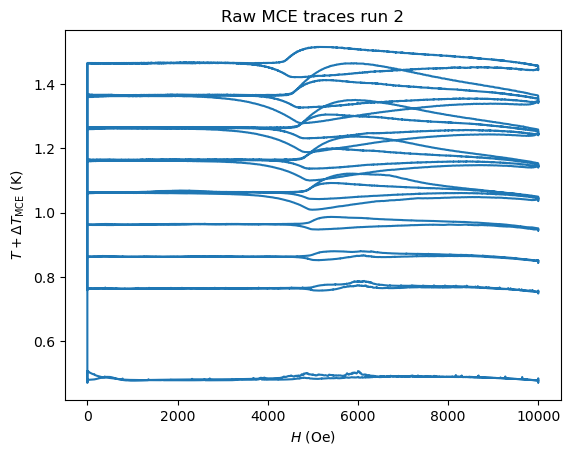

In [9]:
# Raw MCE traces
runID = 2
%matplotlib inline
fig = plt.figure()
plt.plot(Hraw[2], Traw[2])
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.title(f'Raw MCE traces run {runID}')

In [10]:
for tup in [(Hsmoothed, Hraw), (Tsmoothed, Traw)]:
    tup[0][2] = gaussian_filter1d(tup[1][2], 10)

Text(0.5, 1.0, 'Smoothed MCE traces run 2')

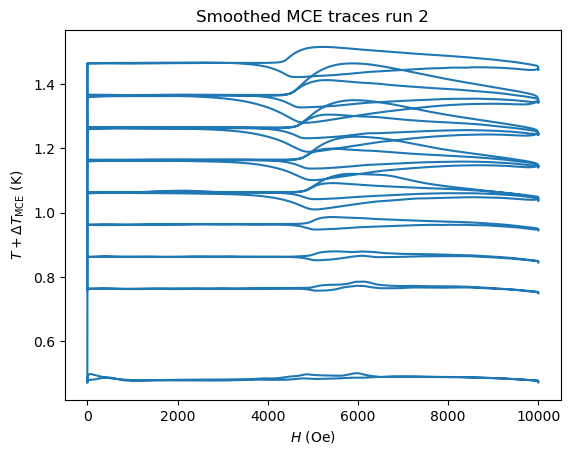

In [11]:
# Smoothed MCE traces
fig = plt.figure()
plt.plot(Hsmoothed[2], Tsmoothed[2])
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.title(f'Smoothed MCE traces run {runID}')

In [12]:
dH[2] = pd.Series(np.diff(Hsmoothed[2]))
dH[2].head

<bound method NDFrame.head of 0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
72121    0.0
72122    0.0
72123    0.0
72124    0.0
72125    0.0
Length: 72126, dtype: float64>

In [13]:
# slow = 4#
# fast = 10#
sweeprates = [4, -4, 10, -10]
refsweep = np.mean([sweeprates[i] for i in [0,2]])

In [14]:
for x in [(Hdict, Hsmoothed, H), (Tdict, Tsmoothed, T),\
          (Tpuck_dict, Tpuck_raw, Tpuck)]:
    for key in [2]:
        if key not in x[0].keys():
            x[0][key] = {}
        Xm = np.mean([x[1][key][:-1], x[1][key][1:]],0)
        x[0][key]['slow up'] = pd.Series(Xm[np.logical_and(dH[key]<refsweep, dH[key]>0)])
        x[0][key]['slow down'] = pd.Series(Xm[np.logical_and(dH[key]>-refsweep, dH[key]<0)])
        x[0][key]['fast up'] = pd.Series(Xm[dH[key]>refsweep])
        x[0][key]['fast down'] = pd.Series(Xm[dH[key]<-refsweep])
        x[2][key] = pd.concat(x[0][key], axis=1)

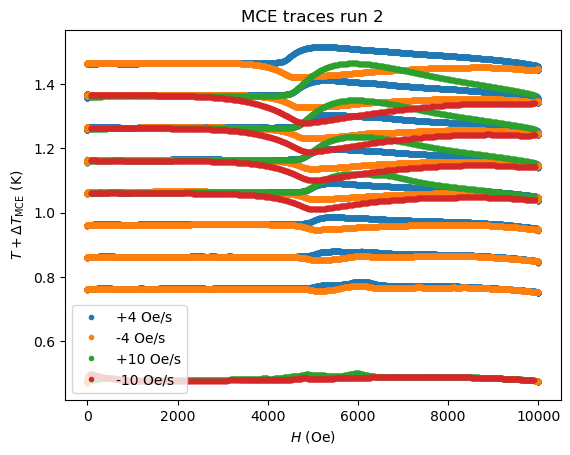

In [15]:
# import ipywidgets as widgets
%matplotlib inline
runID = 2
fig = plt.figure()
for i, s in enumerate(H[2].columns):
    plt.plot(H[runID][s], T[runID][s], '.', label=f'{sweeprates[i]:+d} Oe/s')
plt.title(f'MCE traces run {runID}')
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.legend()

In [16]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_no_demag as mce
from importlib import reload  
# mce = reload(mce)# if mce is changed

In [75]:
mce_sim = {}
mce_fit = {}

In [81]:
# import ipywidgets as widgets
%matplotlib 
runID = 2
mce_fit[runID] = {}
speed = {0:'slow', 2:'fast'}
speed_idx = 2
fig = plt.figure()
for i, s in enumerate(['up', 'down']):
    srlabel = f'{speed[speed_idx]} {s}'
    Tfilter = np.round(Tpuck[runID][srlabel],1)==1.
    Hf = H[runID][srlabel][Tfilter]
    Tf = T[runID][srlabel][Tfilter]
    Tbath = np.mean(Tf[Hf<2e3])
    sweeprate = sweeprates[i+speed_idx]
    prms = mce.mce_parameters(sweeprate=sweeprate, Tbath=Tbath)
    Hc0 = prms['Hc0'].value
    Tc0 = prms['Tc0'].value
    trace_str = f'{s}sweep'
#     mce_sim[s] = pd.DataFrame(mce.mce_residual(prms, Hf, data=Tf, trace=trace_str))
    out = minimize(mce.mce_residual, prms, args=(Hf[Hf<8e3],),\
                   kws={'data':Tf[Hf<8e3], 'trace':trace_str})
    mce_fit[runID][srlabel] = out
#     out = minimize(mce.mce_residual, prms, args=(Hf,))
    mce_sim[s] = mce.mce_residual(out.params, Hf, data=None, trace=trace_str)
    plt.plot(Hf, Tf, '.', label=f'data {sweeprate:+d} Oe/s')
    plt.plot(Hf, mce_sim[s], '.', label=f'fit {sweeprate:+d} Oe/s')
plt.title(f'MCE traces run {runID}')
plt.xlabel(xlabel_mce)
plt.ylabel(ylabel_mce)
plt.legend()

Using matplotlib backend: Qt5Agg
